### 1. Setup and Imports

In [15]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


### 2. Load Socio- economic data

In [16]:
def load_csv_data(base_dir: Path, file_name: str):
    """
    Loads a CSV file from the specified directory.
    """
    return pd.read_csv(base_dir / file_name)

# Define paths
socio_path = Path("data/raw/socio-economic/")

# Load socio-economic dataset
socio_data = load_csv_data(socio_path, "eco-socio-env-health-edu-dev-energy_npl.csv")

# Show the first few rows of data
socio_data.head()


,Country Name,Country ISO3,Year,Indicator Name,Indicator Code,Value
0,Nepal,NPL,1983,Fertilizer consumption (% of fertilizer produc...,AG.CON.FERT.PT.ZS,129.065744
1,Nepal,NPL,2022,Fertilizer consumption (kilograms per hectare ...,AG.CON.FERT.ZS,67.843176
2,Nepal,NPL,2021,Fertilizer consumption (kilograms per hectare ...,AG.CON.FERT.ZS,112.610654
3,Nepal,NPL,2020,Fertilizer consumption (kilograms per hectare ...,AG.CON.FERT.ZS,115.325540
4,Nepal,NPL,2019,Fertilizer consumption (kilograms per hectare ...,AG.CON.FERT.ZS,97.005587


### 3. Process socio - economic indicator

In [17]:
# Create a mapping dictionary for the indicators
indicator_map = {
    'Agricultural land (sq. km)': 'agricultural_land',
    'Permanent cropland (% of land area)': 'cropland_percentage',
    'Population density (people per sq. km of land area)': 'population_density',
    'Fertilizer consumption (kilograms per hectare of arable land)': 'fertilizer_consumption_per_ha'
}

# Filter relevant data and clean up
filtered_data = socio_data[socio_data['Indicator Name'].isin(indicator_map.keys())]
filtered_data = filtered_data[['Year', 'Indicator Name', 'Value']]

# Group by 'Year' and 'Indicator Name' to calculate the average
filtered_data = filtered_data.groupby(['Indicator Name', 'Year'], as_index=False).agg(Value=('Value', 'mean'))

# Rename the indicators and reshape data
filtered_data['Indicator Name'] = filtered_data['Indicator Name'].map(indicator_map)
socio_data_wide = filtered_data.pivot(index='Year', columns='Indicator Name', values='Value').reset_index()

# Fill missing values using the median
for column in socio_data_wide.columns:
    if column != 'Year':
        socio_data_wide[column] = socio_data_wide[column].fillna(socio_data_wide[column].median())

# Rename 'Year' column for consistency
socio_data_wide.rename(columns={'Year': 'year'}, inplace=True)

socio_data_wide.head()


Indicator Name,year,agricultural_land,cropland_percentage,fertilizer_consumption_per_ha,population_density
0,1961,35530.0,0.174825,0.082503,72.156615
1,1962,35530.0,0.174825,0.238649,73.574238
2,1963,35630.0,0.174825,0.347467,75.033692
3,1964,35530.0,0.174825,0.565891,76.548196
4,1965,35530.0,0.174825,0.614064,78.135741


### 4. Loading climate data

In [18]:
climate_data_path = Path("data/raw/climate/")

# Define climate data files and their corresponding column names
climate_file_mapping = {
    "observed-annual-average_temp.csv": "avg_temperature",
    "observed-annual-average-min-temp.csv": "min_temperature",
    "observed-annual-average-max-temp.csv": "max_temperature",
    "observed-annual-relative-humidity.csv": "humidity_level",
    "observed_annual-average-largest-1-day-precipitation.csv": "max_precipitation"
}

# Load each climate file and rename columns accordingly
climate_dfs = {}
for file_name, col_name in climate_file_mapping.items():
    climate_df = load_csv_data(climate_data_path, file_name)
    climate_dfs[col_name] = climate_df.set_index('Category')['Annual Mean']

# Combine into one DataFrame
climate_combined = pd.DataFrame(climate_dfs).reset_index().rename(columns={'Category': 'year'})

climate_combined.head()


,year,avg_temperature,min_temperature,max_temperature,humidity_level,max_precipitation
0,1950,11.24,6.66,15.71,74.93,88.27
1,1951,11.21,6.53,15.84,74.99,91.14
2,1952,10.84,6.42,15.23,78.17,74.80
3,1953,10.90,6.42,15.38,77.45,102.32
4,1954,11.48,6.71,16.24,70.61,125.67


#### 4.1 Rainfall data

In [19]:
rainfall_data = load_csv_data(climate_data_path, "npl-rainfall-adm2-full.csv")

# Remove any duplicated header row
rainfall_data = rainfall_data.drop(index=0)

# Parse 'date' column into datetime and extract year
rainfall_data['date'] = pd.to_datetime(rainfall_data['date'])
rainfall_data['rfh'] = pd.to_numeric(rainfall_data['rfh'], errors='coerce')
rainfall_data['year'] = rainfall_data['date'].dt.year

# Calculate annual mean rainfall
annual_rainfall = rainfall_data.groupby('year')['rfh'].mean().reset_index(name='annual_rainfall')

# Merge with the climate data
climate_combined = climate_combined.merge(annual_rainfall, on='year', how='outer')

# Fill missing values with column mean
climate_combined.fillna(climate_combined.mean(numeric_only=True), inplace=True)

climate_combined.head()


C:\Users\shaha\AppData\Local\Temp\ipykernel_10208\669891131.py:5: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(base_dir / file_name)


,year,avg_temperature,min_temperature,max_temperature,humidity_level,max_precipitation,annual_rainfall
0,1950,11.24,6.66,15.71,74.93,88.27,41.292567
1,1951,11.21,6.53,15.84,74.99,91.14,41.292567
2,1952,10.84,6.42,15.23,78.17,74.80,41.292567
3,1953,10.90,6.42,15.38,77.45,102.32,41.292567
4,1954,11.48,6.71,16.24,70.61,125.67,41.292567


### 5. Merge Socio economic and Climate data

In [20]:
final_combined = pd.merge(climate_combined, socio_data_wide, on='year', how='outer')

# Final imputation for any remaining missing values
final_combined.fillna(final_combined.mean(numeric_only=True), inplace=True)

final_combined.head()


,year,avg_temperature,min_temperature,max_temperature,humidity_level,max_precipitation,annual_rainfall,agricultural_land,cropland_percentage,fertilizer_consumption_per_ha,population_density
0,1950,11.24,6.66,15.71,74.93,88.27,41.292567,40334.66129,0.537348,27.372378,141.571356
1,1951,11.21,6.53,15.84,74.99,91.14,41.292567,40334.66129,0.537348,27.372378,141.571356
2,1952,10.84,6.42,15.23,78.17,74.80,41.292567,40334.66129,0.537348,27.372378,141.571356
3,1953,10.90,6.42,15.38,77.45,102.32,41.292567,40334.66129,0.537348,27.372378,141.571356
4,1954,11.48,6.71,16.24,70.61,125.67,41.292567,40334.66129,0.537348,27.372378,141.571356


### 6. EDA

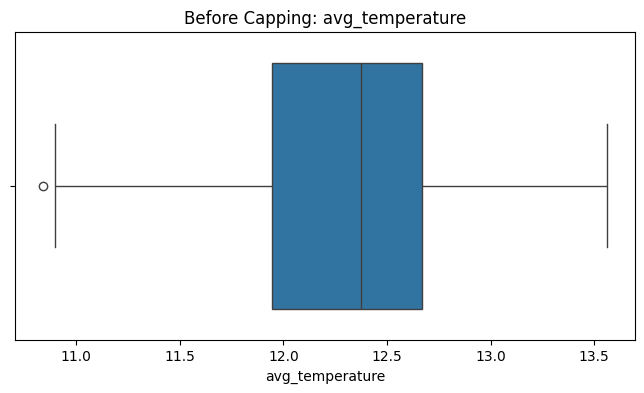

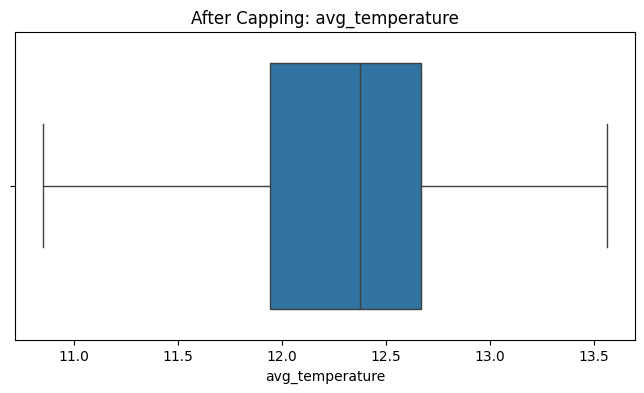

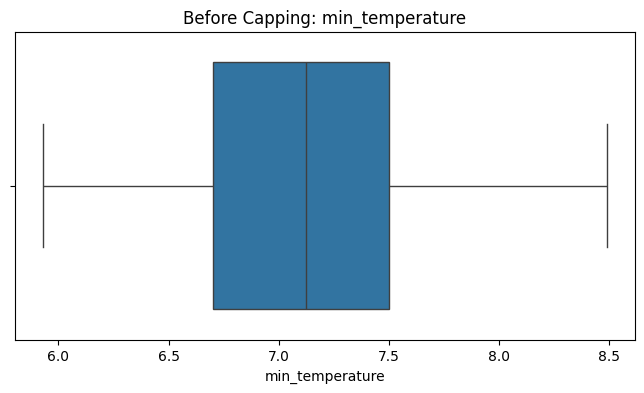

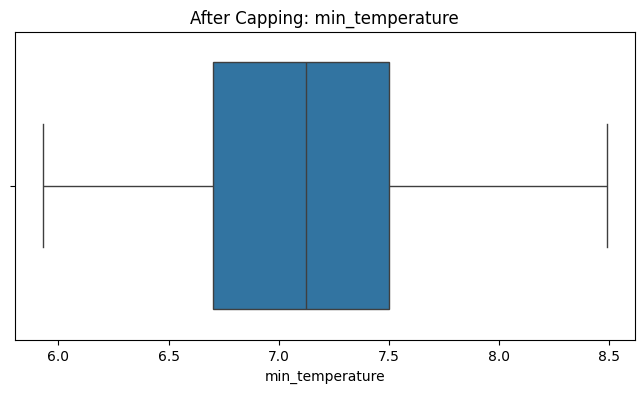

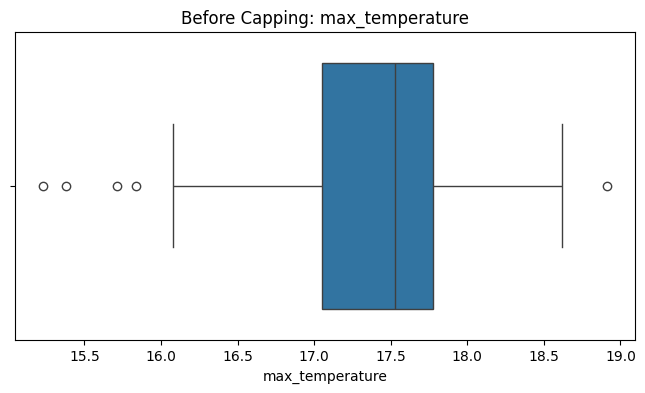

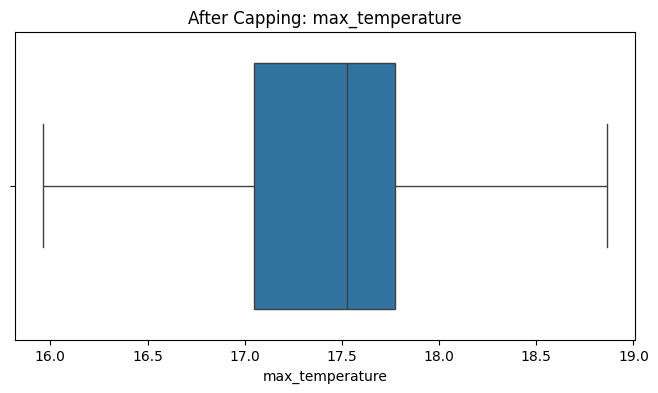

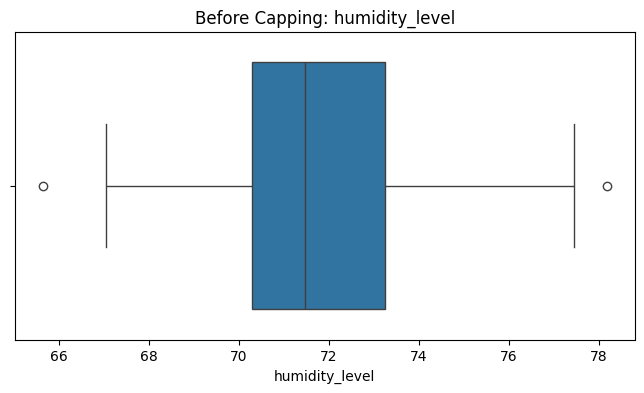

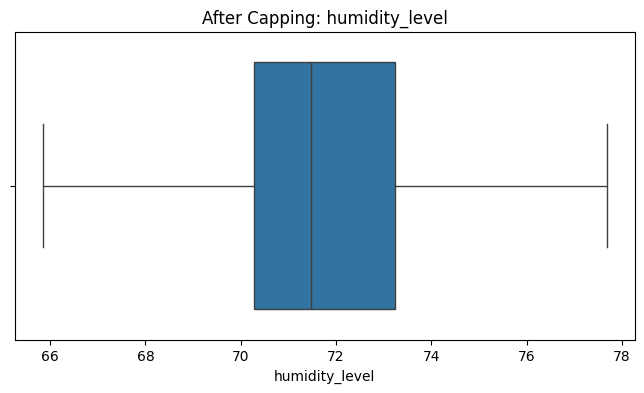

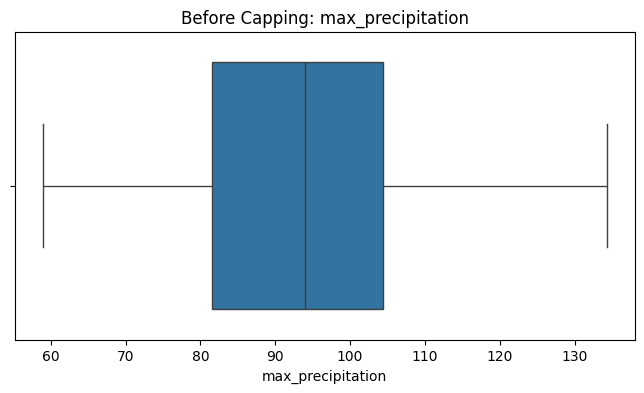

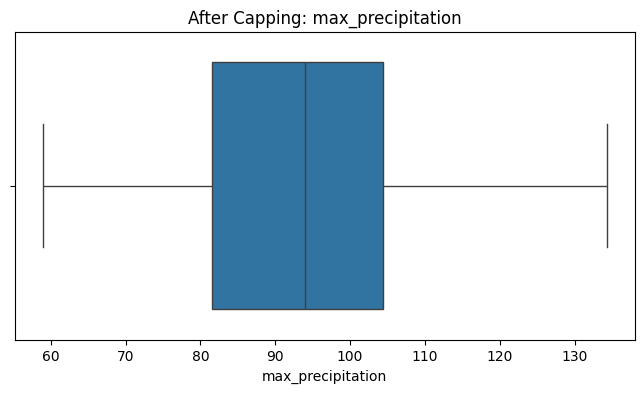

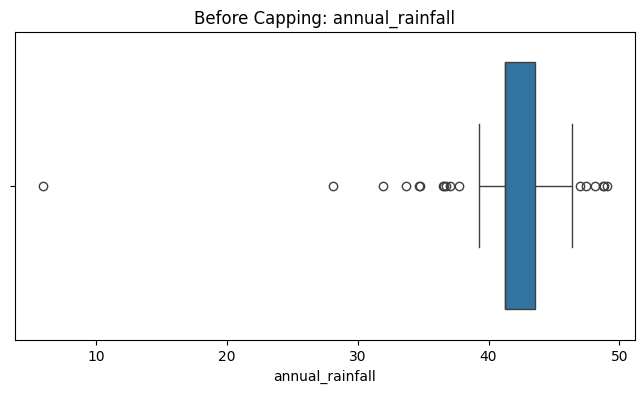

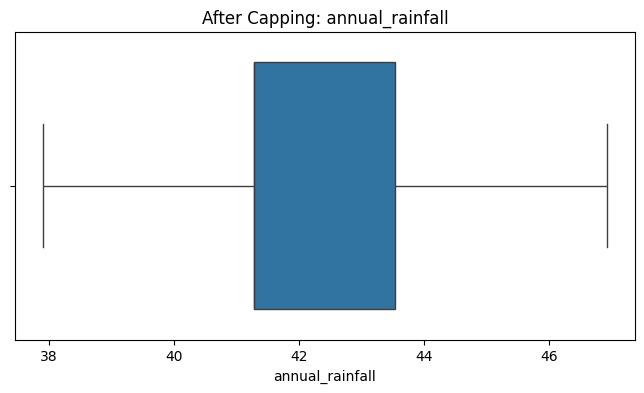

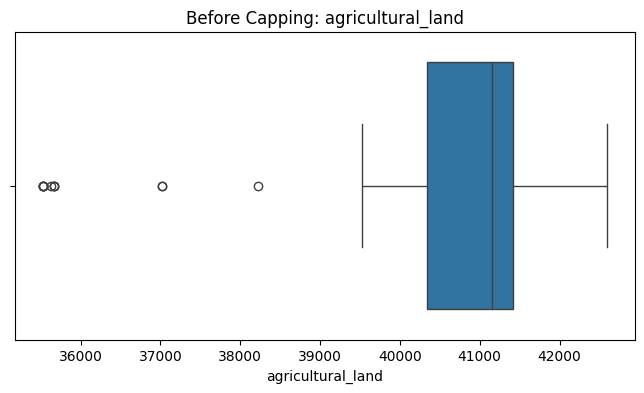

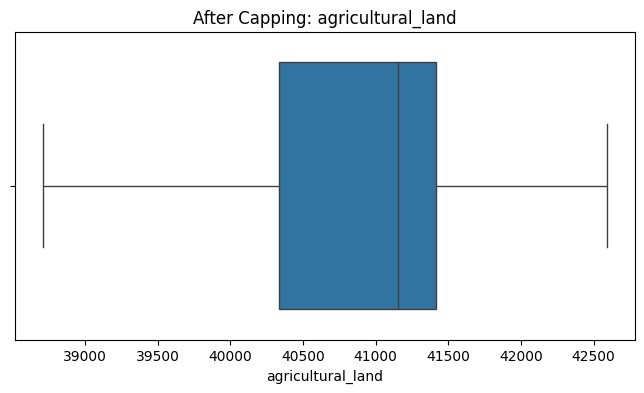

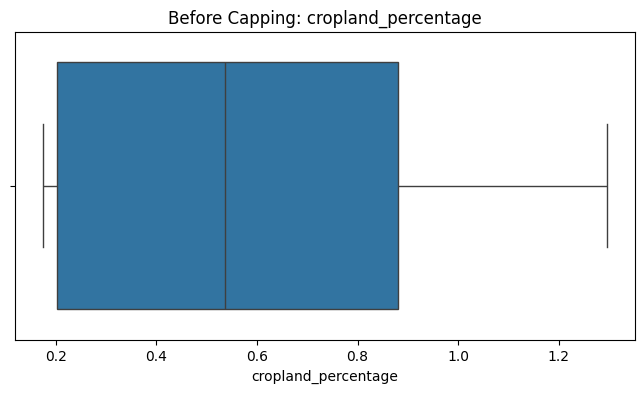

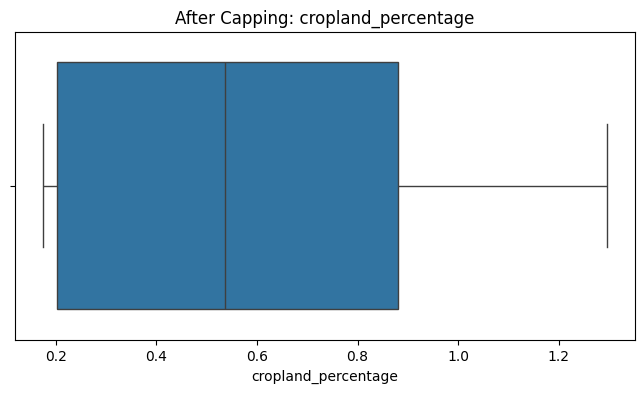

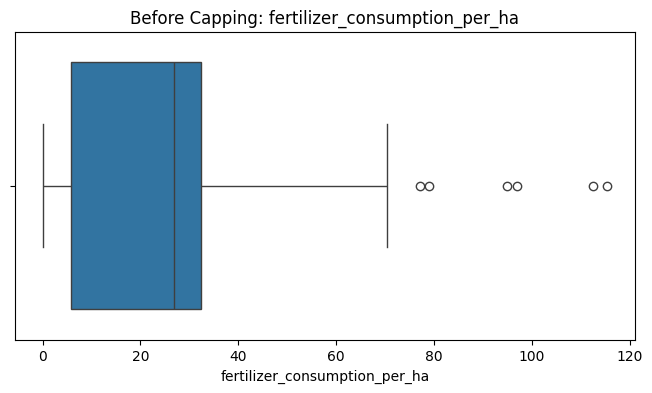

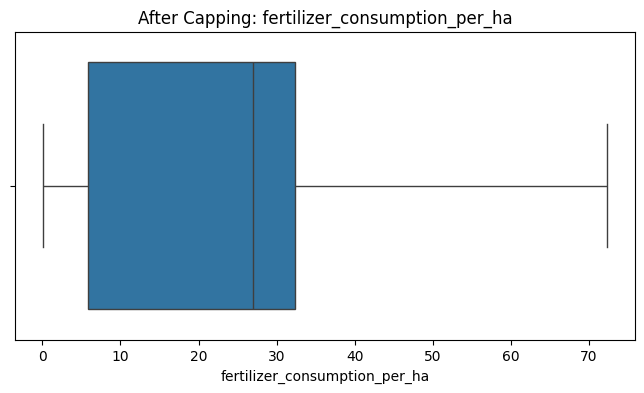

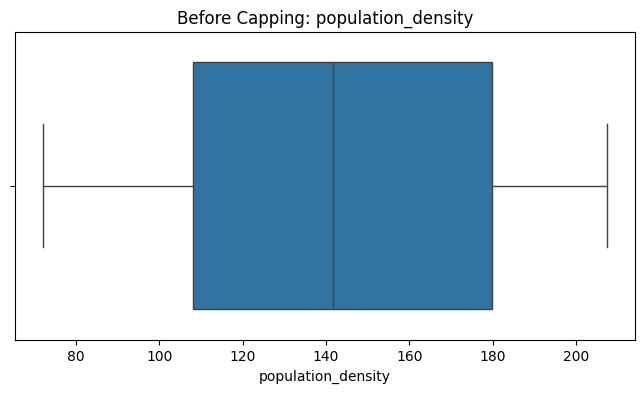

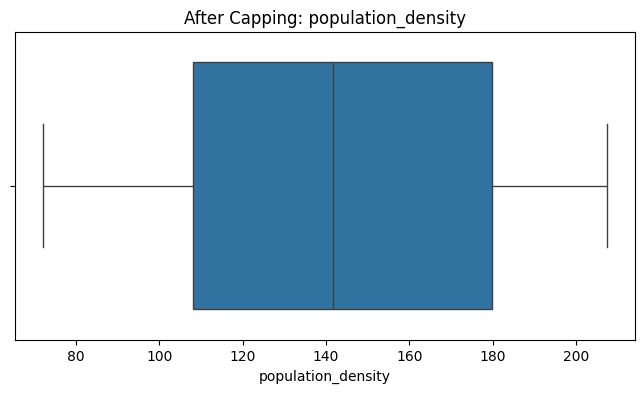

In [21]:
numerical_columns = final_combined.select_dtypes(include=[np.number]).columns.drop('year')

# Function to cap outliers based on IQR method
def apply_iqr_capping(data_series: pd.Series) -> pd.Series:
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data_series.clip(lower=lower_bound, upper=upper_bound)

# Apply the capping to numerical columns and visualize
for column in numerical_columns:
    # Plot before capping
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=final_combined[column])
    plt.title(f"Before Capping: {column}")
    plt.show()

    # Apply the capping
    final_combined[column] = apply_iqr_capping(final_combined[column])

    # Plot after capping
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=final_combined[column])
    plt.title(f"After Capping: {column}")
    plt.show()


### 7. Save Process data

In [22]:
output_dir = Path("data/processed_data")
output_dir.mkdir(parents=True, exist_ok=True)

final_combined.to_csv(output_dir / "final_combined_data.csv", index=False)
print(f"Processed data saved to {output_dir / 'final_combined_data.csv'}")


Processed data saved to data\processed_data\final_combined_data.csv
